In [ ]:
import os
import re
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from lxml import etree
from lxml.etree import XMLSyntaxError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## **XML files to single CSV => Filename, URL, Sentence_Id, Tokens, Tags**

In [ ]:

# List of abbreviations where sentences should not split
EXCEPTIONS = ['Dr.', 'Mr.', 'Inc.', 'Mrs.', 'Prof.', 'Sr.', 'Jr.', 'Rs.']


def sanitize_xml(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read()

    # Replace unescaped '&' characters with '&amp;', excluding already escaped entities
    content = re.sub(r'&(?!amp;|lt;|gt;|quot;|apos;)', '&amp;', content)

    # Ensure the file starts with a valid XML declaration if needed
    if not content.startswith("<?xml"):
        content = "<?xml version='1.0' encoding='UTF-8'?>\n" + content

    # Save sanitized XML
    sanitized_path = file_path + ".sanitized"
    with open(sanitized_path, "w", encoding="utf-8") as file:
        file.write(content)

    # Validate the XML and auto-fix if necessary
    parser = etree.XMLParser(recover=True, huge_tree=True)
    try:
        etree.parse(sanitized_path, parser)  # Attempt to parse
    except XMLSyntaxError as e:
        print(f"Warning: XML syntax error in {file_path}: {e}. Attempting auto-repair...")

    return sanitized_path


# Function to check if a token is an abbreviation or date
def is_exception_or_date(token):
    if re.match(r'\d{1,2}[\.\/-]\d{1,2}[\.\/-]\d{4}', token):
        return True
    if token in EXCEPTIONS:
        return True
    return False


# Function to extract the URL from the first sentence
def extract_url(root):
    # Get the first sentence
    first_sentence = root.xpath("//sentence[1]")

    if first_sentence:
        words = first_sentence[0].xpath(".//word")

        if len(words) >= 1:
            first_word = words[0].text.strip() if words[0].text else ""

            if first_word.startswith("#") and len(words) > 1:
                # If first word starts with #, take the next word
                return words[1].text.strip() if words[1].text else "N/A"
            else:
                # Otherwise, take the first word as URL
                return first_word

    return "N/A"  # Default if no valid URL is found




# Main function to parse XML and save to CSV
def parse_xml_to_csv(input_folder, output_csv):
    data = []

    for file in os.listdir(input_folder):
        if file.endswith(".xml"):
            filename = file
            file_path = os.path.join(input_folder, file)
            sanitized_path = sanitize_xml(file_path)
            parser = etree.XMLParser(huge_tree=True)
            tree = etree.parse(sanitized_path, parser)
            root = tree.getroot()

            # Extract URL only once per file
            url = extract_url(root)
            if url == "N/A":
                print(f"⚠️ Warning: No URL found in {filename}")

            sentence_id = 0
            tokens, tags = [], []

            for sentence in root.xpath("//sentence"):
                words = sentence.xpath(".//word")

                for i, word in enumerate(words):
                    token = word.text.strip() if word.text else ""
                    tag = word.get("tag")

                    next_word = words[i + 1].text.strip() if (i + 1 < len(words) and words[i + 1].text) else None
                    next_tag = words[i + 1].get("tag") if i + 1 < len(words) else None

                    if token.endswith("."):
                        before_dot = token[:-1]
                        if len(before_dot) == 1 or (len(before_dot) >= 2 and is_exception_or_date(token)):
                            tokens.append(token)
                            tags.append(tag)
                            continue
                        if next_tag and next_tag.startswith("i-"):
                            tokens.append(token)
                            tags.append(tag)
                            continue
                        tokens.append(token)
                        tags.append(tag)
                        data.append([filename, url, sentence_id, " ".join(tokens), " ".join(tags)])
                        sentence_id += 1
                        tokens, tags = [], []
                    else:
                        tokens.append(token)
                        tags.append(tag)

                if tokens:
                    data.append([filename, url, sentence_id, " ".join(tokens), " ".join(tags)])
                    sentence_id += 1
                    tokens, tags = [], []

    with open(output_csv, mode="w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Filename", "URL", "Sentence_Id", "Tokens", "Tags"])
        writer.writerows(data)

    print(f"✅ CSV saved to {output_csv}")


# Example usage
input_folder = r"C:\Users\plura\Desktop\NER\KHASI_NER\Khasi Keyword Identification-20250219T102319Z-001\Khasi Keyword Identification"
output_csv = "khasi_key_datasetv0.csv"
parse_xml_to_csv(input_folder, output_csv)


⚠️ Warning: No URL found in File11_20112024_mawphor.xml
⚠️ Warning: No URL found in File12_20112024_mawphor.xml
✅ CSV saved to khasi_key_datasetv0.csv


## **Fix encoding issue, if any**

In [ ]:

csv_file = r"_khasi_ner_datasetv0.csv"  # Your CSV file

# Read CSV with correct encoding
df = pd.read_csv(csv_file, encoding="utf-8-sig")

# Clean URL column
df["URL"] = df["URL"].apply(lambda x: x[5:].strip() if isinstance(x, str) and (x.startswith("#URL:") or x.startswith("#url")) else x)

# Save the cleaned file with correct encoding
output_file = "khasi_ner_datasetv1.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"✅ Encoding issues fixed and saved as {output_file}")


## **Fix unnecessary and wrong sentence breaking**

In [ ]:

def merge_i_tags(input_csv, output_csv):
    merged_data = []

    with open(input_csv, mode="r", encoding="utf-8") as csvfile:
        reader = list(csv.reader(csvfile))
        header = reader[0]  # Save the header
        rows = reader[1:]  # Data rows

        for row in rows:
            filename, url, sentence_id, tokens, tags = row

            # Check if first tag in tags starts with "i-"
            if tags.split()[0].startswith("i-") and merged_data:
                # Append tokens and tags to the last row
                merged_data[-1][3] += " " + tokens
                merged_data[-1][4] += " " + tags
            else:
                # Add new row to merged_data
                merged_data.append(row)

    # Save the merged data back to CSV
    with open(output_csv, mode="w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)  # Write header
        writer.writerows(merged_data)  # Write updated rows

    print(f"Processed CSV saved as {output_csv}")

# Example usage
input_csv = r"khasi_ner_datasetv1.csv"
output_csv = r"khasi_ner_datasetv2.csv"
merge_i_tags(input_csv, output_csv)


Processed CSV saved as khasi_ner_datasetv2.csv


## **Remove Metadata rows from csv**

In [ ]:

def remove_metadata_rows(input_csv, output_csv):
    with open(input_csv, mode="r", encoding="utf-8") as infile:
        reader = csv.reader(infile)
        header = next(reader)  # Read the header

        filtered_rows = [header]  # Keep the header
        for row in reader:
            tokens = row[3].strip()  # "Tokens" column is the 3rd column (index 2)
            if not tokens.startswith("#"):  # Skip rows where tokens start with '#'
                filtered_rows.append(row)

    # Write the filtered rows to a new CSV
    with open(output_csv, mode="w", newline="", encoding="utf-8") as outfile:
        writer = csv.writer(outfile)
        writer.writerows(filtered_rows)

    print(f"Metadata rows removed. Cleaned CSV saved to {output_csv}")

# Example usage
input_csv = r"khasi_ner_datasetv2.csv" # Replace with your input CSV path
output_csv = r"khasi_ner_datasetv3.csv"  # Output file path
remove_metadata_rows(input_csv, output_csv)


Metadata rows removed. Cleaned CSV saved to khasi_ner_datasetv3.csv


## **Removing some very small length rows (optional)**

In [ ]:

def clean_csv(input_csv, output_csv):
    cleaned_data = []

    with open(input_csv, mode="r", encoding="utf-8") as csvfile:
        reader = list(csv.reader(csvfile))
        header = reader[0]  # Save header
        rows = reader[1:]  # Data rows

        for row in rows:
            filename, url, sentence_id, tokens, tags = row

            # Remove rows starting with specific phrases
            if tokens.startswith("Date & Time:") or tokens.startswith("Data Collected by"):
                continue

            # Remove rows where "Tags" contain only "O" or "O O"
            if tags.strip() in ["O", "O O", "O O O", "O O O O", "O O O O O"]:
                continue

            # Keep the row if it doesn't meet the removal conditions
            cleaned_data.append(row)

    # Save cleaned data back to CSV
    with open(output_csv, mode="w", newline="", encoding="utf-8") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(header)  # Write header
        writer.writerows(cleaned_data)  # Write updated rows

    print(f"Cleaned CSV saved as {output_csv}")

# Example usage
input_csv = r"khasi_ner_datasetv3.csv"
output_csv = "khasi_ner_datasetv4.csv"
clean_csv(input_csv, output_csv)


Cleaned CSV saved as khasi_ner_datasetv4.csv


## **Removing unnecessary columns**

In [ ]:

def remove_columns(input_csv, output_csv):
    with open(input_csv, mode="r", encoding="utf-8") as infile:
        reader = csv.reader(infile)
        header = next(reader)

        # Get indices of "Filename" and "Sentence_Id" columns
        filename_idx = header.index("Filename")
        sentence_id_idx = header.index("Sentence_Id")

        # Remove the columns from the header
        new_header = [col for i, col in enumerate(header) if i not in (filename_idx, sentence_id_idx)]

        # Filter rows by removing the corresponding columns
        filtered_rows = [new_header]
        for row in reader:
            new_row = [col for i, col in enumerate(row) if i not in (filename_idx, sentence_id_idx)]
            filtered_rows.append(new_row)

    # Write the filtered rows to a new CSV
    with open(output_csv, mode="w", newline="", encoding="utf-8") as outfile:
        writer = csv.writer(outfile)
        writer.writerows(filtered_rows)

    print(f"Columns removed. Cleaned CSV saved to {output_csv}")

# Example usage
input_csv = "cleaned_output_dataset.csv"  # Replace with your input CSV path
output_csv = "final_output_dataset.csv"  # Output file path
remove_columns(input_csv, output_csv)


Columns removed. Cleaned CSV saved to final_output_dataset.csv


## **Checking if any row start with i-tag? if then it will handle it**

In [ ]:

def check_i_tag_rows(csv_file):
    with open(csv_file, mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        header = next(reader)  # Skip the header row
        tag_index = header.index("Tags")  # Get index of Tags column

        row_numbers = []
        for row_num, row in enumerate(reader, start=2):  # Start from 2 to account for header
            tags = row[tag_index].split()
            if tags and tags[0].startswith("i-"):
                row_numbers.append(row_num)

        if row_numbers:
            print("Rows where the first tag starts with 'i-':", row_numbers)
        else:
            print("No rows found where the first tag starts with 'i-'.")

# Example usage
csv_file = r"khasi_ner_datasetv1.csv"  # Replace with your actual CSV filename
check_i_tag_rows(csv_file)


No rows found where the first tag starts with 'i-'.


## **CSV to CONLL format**

In [ ]:

def csv_to_conll(csv_file, conll_file):
    total_sentences = 0
    total_tokens = 0
    unique_tokens = set()
    tag_counts = defaultdict(int)  # Dictionary to count tags (merge b- and i-)

    with open(csv_file, mode='r', encoding='utf-8-sig') as file, open(conll_file, mode='w', encoding='utf-8') as out_file:
        reader = csv.reader(file)
        header = next(reader)  # Read header row and remove BOM

        # Remove BOM from the first column
        header[0] = header[0].lstrip("\ufeff")

        filename_index = header.index("Filename")  # Now it should work fine
        url_index = header.index("URL")
        sentence_id_index = header.index("Sentence_Id")
        tokens_index = header.index("Tokens")
        tags_index = header.index("Tags")

        for row in reader:
            url = row[url_index]
            sentence_id = row[sentence_id_index]
            tokens = row[tokens_index].split()
            tags = row[tags_index].split()

            # Update statistics
            total_sentences += 1
            total_tokens += len(tokens)
            unique_tokens.update(tokens)  # Add tokens to set for unique count

            for tag in tags:
                normalized_tag = tag.replace("b-", "").replace("i-", "")  # Merge b- and i- tags
                tag_counts[normalized_tag] += 1

            # Write headers for each sentence
            out_file.write(f"# URL: {url}\n")
            out_file.write(f"# Sentence_Id: {sentence_id}\n")

            # Write tokens with token ID
            for i, (token, tag) in enumerate(zip(tokens, tags), start=1):
                out_file.write(f"{i}\t{token}\t  {tag}\n")

            out_file.write("\n")  # Sentence separator

    # Print the statistics
    print(f"Total Sentences: {total_sentences}")
    print(f"Total Tokens: {total_tokens}")
    print(f"Unique Tokens: {len(unique_tokens)}")
    print("Tag-wise Count:")
    for tag, count in tag_counts.items():
        print(f"  {tag}: {count}")

    print(f"\nCoNLL file saved to {conll_file}")

# Example usage
csv_file = r"Khasi_NER_merged_dataset.csv"
conll_file = "Khasi_NER_merged_dataset.conll"
csv_to_conll(csv_file, conll_file)


CoNLL file saved to Mizo_output_dataset.conll


## **Split conll into train test valid**

In [ ]:

def read_conll_file(conll_file):
    """ Reads a CoNLL file and extracts sentences as structured data. """
    sentences = []
    current_sentence = []
    current_url = ""

    with open(conll_file, mode="r", encoding="utf-8") as file:
        for line in file:
            line = line.strip()

            if line.startswith("# URL:"):
                current_url = line  # Store URL header
            elif line.startswith("# Sentence_Id:"):
                continue  # Ignore sentence ID because we'll renumber
            elif line == "":
                if current_sentence:
                    sentences.append((current_url, current_sentence))
                    current_sentence = []
            else:
                # Replace HEADLINE with HEADWORD
                current_sentence.append(line.replace("HEADLINE", "KEYWORD"))

        if current_sentence:  # Add last sentence if file doesn't end with newline
            sentences.append((current_url, current_sentence))

    return sentences

def write_conll_file(sentences, output_file):
    """ Writes sentences to a new CoNLL file with corrected numbering. """
    with open(output_file, mode="w", encoding="utf-8") as file:
        for i, (url, sentence) in enumerate(sentences, start=1):
            file.write(f"{url}\n")
            file.write(f"# Sentence_Id: {i}\n")  # Renumber sentence IDs

            for line in sentence:
                file.write(line + "\n")

            file.write("\n")  # Sentence separator

def compute_stats(sentences):
    """ Computes statistics for a given dataset split. """
    total_sentences = len(sentences)
    total_tokens = 0
    unique_tokens = set()
    tag_counts = defaultdict(int)

    for _, sentence in sentences:
        for line in sentence:
            parts = line.split("\t")
            if len(parts) < 3:
                continue
            token = parts[1].strip()
            tag = parts[2].strip()

            total_tokens += 1
            unique_tokens.add(token)

            normalized_tag = tag.replace("b-", "").replace("i-", "")  # Merge b- and i-
            tag_counts[normalized_tag] += 1

    return {
        "Total Sentences": total_sentences,
        "Total Tokens": total_tokens,
        "Unique Tokens": len(unique_tokens),
        "Tag Counts": dict(tag_counts),
    }

def split_and_save(conll_file, train_ratio=0.8, valid_ratio=0.1, test_ratio=0.1):
    """ Splits the dataset into train, valid, and test sets, then saves them. """
    sentences = read_conll_file(conll_file)
    random.shuffle(sentences)  # Shuffle for random splits

    total = len(sentences)
    train_size = int(total * train_ratio)
    valid_size = int(total * valid_ratio)

    train_set = sentences[:train_size]
    valid_set = sentences[train_size:train_size + valid_size]
    test_set = sentences[train_size + valid_size:]

    # Save split files
    write_conll_file(train_set, "train.conll")
    write_conll_file(valid_set, "valid.conll")
    write_conll_file(test_set, "test.conll")

    # Compute stats
    train_stats = compute_stats(train_set)
    valid_stats = compute_stats(valid_set)
    test_stats = compute_stats(test_set)

    # Print stats
    print("\n=== Dataset Statistics ===")
    print("Train Set:", train_stats)
    print("Validation Set:", valid_stats)
    print("Test Set:", test_stats)

# Example Usage
conll_file = r"Khasi_NER_merged_dataset.conll" # Your original CoNLL file
split_and_save(conll_file)



=== Dataset Statistics ===
Train Set: {'Total Sentences': 3303, 'Total Tokens': 162051, 'Unique Tokens': 13039, 'Tag Counts': {'O': 140458, 'NEL': 1893, 'NETI': 2313, 'NEMI': 3564, 'NEO': 1345, 'NEP': 2047, 'NEF': 1099, 'KEYWORD': 9025, 'NEAR': 301, 'NEU': 3, 'NETE': 3}}
Validation Set: {'Total Sentences': 412, 'Total Tokens': 21370, 'Unique Tokens': 3754, 'Tag Counts': {'KEYWORD': 1451, 'O': 18288, 'NEAR': 44, 'NEMI': 463, 'NEL': 278, 'NEP': 264, 'NETI': 210, 'NEF': 164, 'NEO': 207, 'NEU': 1}}
Test Set: {'Total Sentences': 414, 'Total Tokens': 19680, 'Unique Tokens': 3680, 'Tag Counts': {'KEYWORD': 899, 'NEMI': 535, 'O': 16974, 'NEL': 272, 'NETI': 272, 'NEAR': 50, 'NEF': 157, 'NEP': 309, 'NEO': 212}}


# **Data Preprocessing**

### Check the Shape of data

In [ ]:

# Load the CSV
df = pd.read_csv("final_output_dataset.csv")  # Replace with your actual file path

# Check the shape (number of rows and columns)
print(f"Shape of the dataset: {df.shape}")


Shape of the dataset: (3565, 2)


### Check first 5 rows

In [ ]:
# Display the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
                                              Tokens  \
0                            Sairangah heroin an man   
1  Mizoram NewsSairangah heroin an man admin 14-S...   
2  Assam Rifles leh Excise & Narcotics Department...   
3  Excise leh AR tangkawp hian an thudawn bawhzui...   
4               Cheng nuai 16.80 man hua chhut a ni.   

                                                Tags  
0        b-HEADLINE i-HEADLINE i-HEADLINE i-HEADLINE  
1                                  O O O O O O O O O  
2  b-NEO i-NEO O b-NEO i-NEO i-NEO i-NEO O O O O ...  
3  O O O O O O O O b-NEMI i-NEMI O O O b-NEL i-NE...  
4                                    O O O O O O O O  


### Check null values

In [ ]:
# Check for null values in each column
print("Null values in the dataset:")
print(df.isnull().sum())


Null values in the dataset:
Tokens    0
Tags      0
dtype: int64


### Check Data statistics

In [ ]:
# Descriptive statistics for token and tag word counts
print("Descriptive statistics for token word counts:")
print(df['Token_Word_Count'].describe())

print("\nDescriptive statistics for tag word counts:")
print(df['Tag_Word_Count'].describe())


Descriptive statistics for token word counts:
count    3565.000000
mean       25.148107
std        23.281133
min         1.000000
25%        10.000000
50%        19.000000
75%        33.000000
max       280.000000
Name: Token_Word_Count, dtype: float64

Descriptive statistics for tag word counts:
count    3565.000000
mean       25.148107
std        23.281133
min         1.000000
25%        10.000000
50%        19.000000
75%        33.000000
max       280.000000
Name: Tag_Word_Count, dtype: float64


### Check Outlier

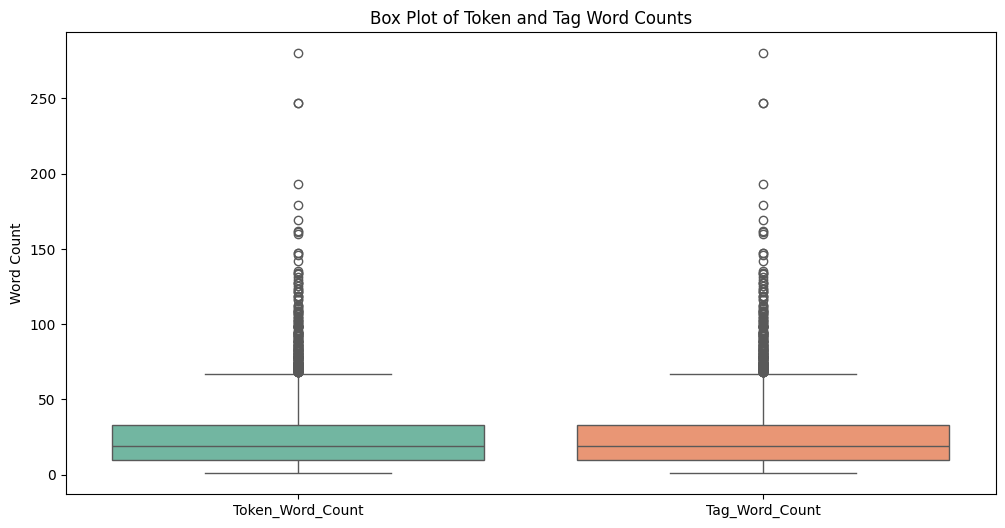

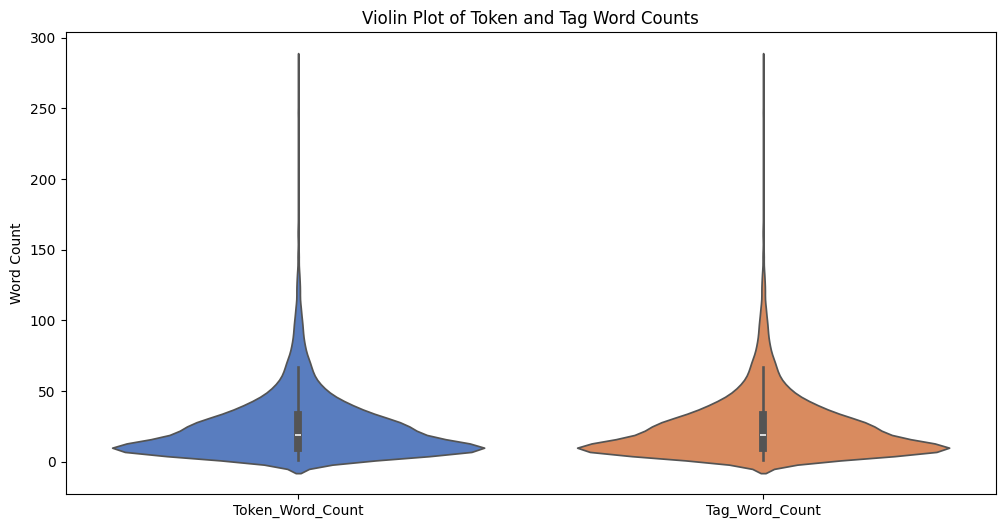

In [ ]:

# Box plot for token and tag word counts
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Token_Word_Count', 'Tag_Word_Count']], palette="Set2")
plt.title("Box Plot of Token and Tag Word Counts")
plt.ylabel("Word Count")
plt.show()

# Violin plot for token and tag word counts
plt.figure(figsize=(12, 6))
sns.violinplot(data=df[['Token_Word_Count', 'Tag_Word_Count']], palette="muted")
plt.title("Violin Plot of Token and Tag Word Counts")
plt.ylabel("Word Count")
plt.show()


### Distribution of Token Word Counts

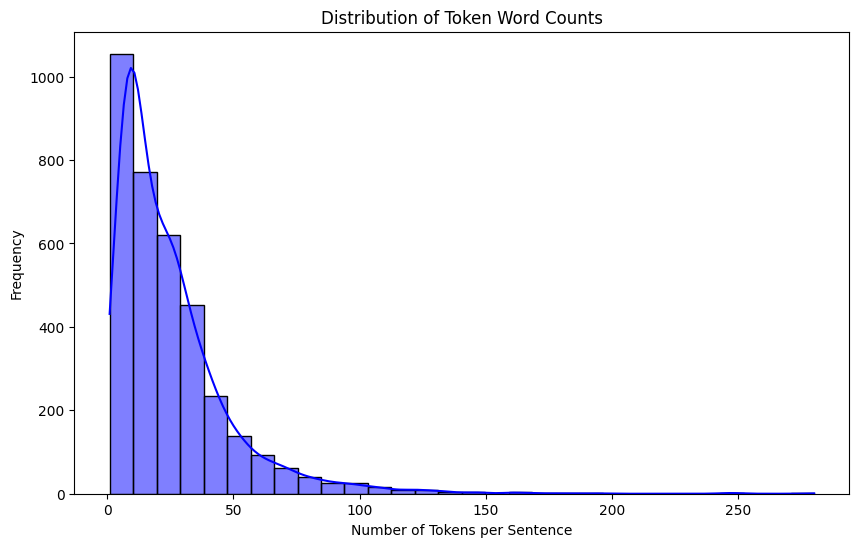

In [ ]:

# Token word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Token_Word_Count'], bins=30, kde=True, color='blue')
plt.title("Distribution of Token Word Counts")
plt.xlabel("Number of Tokens per Sentence")
plt.ylabel("Frequency")
plt.show()


### Tag Frequency Distribution

C:\Users\plura\AppData\Local\Temp\ipykernel_20824\2204968071.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette='viridis')


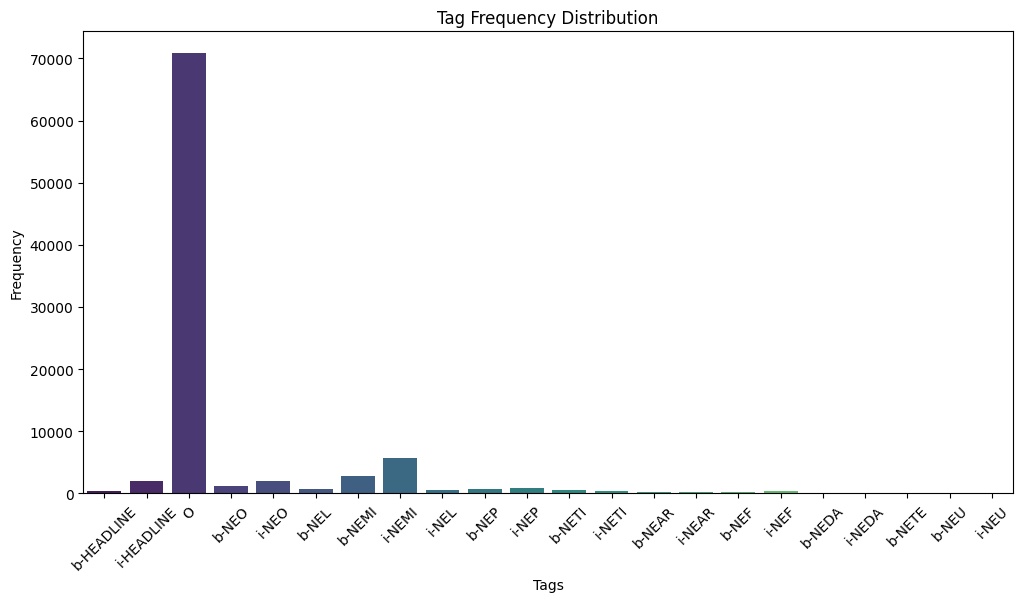

In [ ]:

# Flatten the tags into a single list
all_tags = " ".join(df['Tags']).split()
tag_counts = Counter(all_tags)

# Plot the most common tags
plt.figure(figsize=(12, 6))
sns.barplot(x=list(tag_counts.keys()), y=list(tag_counts.values()), palette='viridis')
plt.title("Tag Frequency Distribution")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


## **Check those conflicting words who has more that 1 tags**

In [ ]:

# Load the dataset
file_path = "cleaned_output_dataset.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 1: Create a column without BIO prefixes
df['Tag_Type'] = df['Tags'].str.replace(r'^[b|i]-', '', regex=True)

# Step 2: Identify tokens with multiple tags across files
def find_conflicting_words_with_details(df):
    # Group by Tokens and Tag_Type, collecting filenames
    grouped = df.groupby(['Tokens', 'Tag_Type'])['Filename'].unique().reset_index()

    # Aggregate tags and filenames for each token
    conflicts = grouped.groupby('Tokens').agg({
        'Tag_Type': lambda x: list(x),
        'Filename': lambda x: list(x)
    }).reset_index()

    # Filter rows where tokens have multiple tags
    conflicts['Tag_Count'] = conflicts['Tag_Type'].apply(len)
    conflicting_words = conflicts[conflicts['Tag_Count'] > 1]

    # Expand the tags and filenames into separate columns
    expanded = []
    for _, row in conflicting_words.iterrows():
        word = row['Tokens']
        tags = row['Tag_Type']
        files = row['Filename']
        row_data = {'Word': word}
        for i, (tag, file_list) in enumerate(zip(tags, files)):
            for file in file_list:
                row_data[f'Tag_{i+1}'] = tag
                row_data[f'File_{i+1}'] = file
        expanded.append(row_data)

    # Create a DataFrame with the expanded data
    expanded_df = pd.DataFrame(expanded)
    return expanded_df

# Process the dataset
conflicting_details = find_conflicting_words_with_details(df)

# Save the output to a CSV file
output_file = "conflicting_words_detailed.csv"
conflicting_details.to_csv(output_file, index=False)

print(f"Detailed conflicting words saved to {output_file}")


Detailed conflicting words saved to conflicting_words_detailed.csv


## **Check Mismatched Rows (length of Tokens != length of Tags)**

In [ ]:

# Load the CSV
df = pd.read_csv("Mizo_NER_merged_datasetv1.csv", encoding="utf-8")

# Function to check token-tag consistency and return details
def check_mismatch(row):
    tokens = str(row["Tokens"]).split()  # Convert tokens column to a list
    tags = str(row["Tags"]).split()  # Convert tags column to a list
    tokens_count = len(tokens)  # Count the number of tokens
    tags_count = len(tags)  # Count the number of tags
    match = tokens_count == tags_count  # Check if counts match

    # Return match status and details
    return pd.Series([match, tokens_count, tags_count, " ".join(tokens), " ".join(tags)])

# Apply the function to each row and store results in new columns
df[["Match", "Token_Count", "Tag_Count", "Tokens_List", "Tags_List"]] = df.apply(check_mismatch, axis=1)

# Extract rows where mismatch occurs
mismatched_rows = df[~df["Match"]]

# Print mismatch summary
print(f"✅ Total Rows Checked: {len(df)}")
print(f"❌ Mismatched Rows Found: {len(mismatched_rows)}")

# Save mismatched rows for debugging
if not mismatched_rows.empty:
    mismatched_rows.to_csv("mismatched_rows.csv", index=False, encoding="utf-8")
    print("⚠️ Mismatched rows saved in 'mismatched_rows.csv' for review.")
else:
    print("🎉 No mismatches found! Tokens and tags are correctly aligned.")

# Save the detailed dataset with match status
df.to_csv("detailed_dataset.csv", index=False, encoding="utf-8")
print("📂 Full dataset with Token/Tag counts saved as 'detailed_dataset.csv'")


✅ Total Rows Checked: 4469
❌ Mismatched Rows Found: 0
🎉 No mismatches found! Tokens and tags are correctly aligned.
📂 Full dataset with Token/Tag counts saved as 'detailed_dataset.csv'


### Split the csv into train test valid split

In [ ]:

# Load the cleaned dataset
df = pd.read_csv("processed_output_dataset.csv")  # Replace with your file path

# Set split ratios
train_ratio = 0.8  # 80% of the data for training
valid_ratio = 0.1  # 10% of the data for validation
test_ratio = 0.1   # 10% of the data for testing

# Split data into train and temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), random_state=42)

# Further split temp into validation and test
valid_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (valid_ratio + test_ratio)), random_state=42)

# Save the splits to separate CSV files
train_df.to_csv("train_dataset.csv", index=False)
valid_df.to_csv("valid_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

print(f"Train, validation, and test sets saved.")
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")


Train, validation, and test sets saved.
Train set size: 2852
Validation set size: 356
Test set size: 357


## Tag encoding

In [ ]:

input_file = "Mizo_NER_merged_datasetv0.csv"
df = pd.read_csv(input_file)

# Initialize LabelEncoder for NER tags only
label_encoder = LabelEncoder()

# Flatten all tags to fit the LabelEncoder, handling empty lists
all_tags = []
for tags_str in df['Tags']:
    try:
        tags = tags_str.split()  # Convert space-separated string to list
        all_tags.extend(tags)  # Add the tags to the list
    except Exception as e:
        # Handle any unexpected errors
        print(f"Skipping invalid tag string: {tags_str}, Error: {e}")

label_encoder.fit(all_tags)

# Function to encode tags using LabelEncoder, handling empty lists
def encode_tags(tags_str):
    try:
        tags = tags_str.split()  # Convert space-separated string to list
        encoded_tags = label_encoder.transform(tags).tolist()  # Transform tags to encoded labels
        return " ".join(map(str, encoded_tags))  # Join encoded tags as a space-separated string
    except Exception as e:
        # Return empty string if tags_str is invalid or empty
        print(f"Error encoding tags: {tags_str}, Error: {e}")
        return ""

# Apply the encoding function to the Tags column
df['encoded_tags'] = df['Tags'].apply(encode_tags)

# Display the dataframe
print(df.head())

# Save the modified DataFrame to a new CSV
output_file = "Mizo_NER_merged_datasetv1.csv"
df.to_csv(output_file, index=False)


                               Filename  \
0  post_mz_mizoramnews_0_5752_412_1.xml   
1  post_mz_mizoramnews_0_5752_412_1.xml   
2  post_mz_mizoramnews_0_5752_412_1.xml   
3  post_mz_mizoramnews_0_5752_412_1.xml   
4  post_mz_mizoramnews_0_5752_412_1.xml   

                                                URL  Sentence_Id  \
0  https://bengvarna.com/post/mz/mizoramnews/0/5752            3   
1  https://bengvarna.com/post/mz/mizoramnews/0/5752            4   
2  https://bengvarna.com/post/mz/mizoramnews/0/5752            5   
3  https://bengvarna.com/post/mz/mizoramnews/0/5752            6   
4  https://bengvarna.com/post/mz/mizoramnews/0/5752            7   

                                              Tokens  \
0                            Sairangah heroin an man   
1  Mizoram NewsSairangah heroin an man admin 14-S...   
2  Assam Rifles leh Excise & Narcotics Department...   
3  Excise leh AR tangkawp hian an thudawn bawhzui...   
4               Cheng nuai 16.80 man hua chhut a ni.

### Get mapping ids

In [ ]:

# Get the original tags
original_tags = label_encoder.classes_
print("Original Tags:")
print(original_tags)

# Create a mapping from encoded values to tag names
tag_mapping = {int(label_encoder.transform([tag])[0]): tag for tag in original_tags}

print("\nTag to Encoded Value Mapping:")
for key, value in tag_mapping.items():
    print(f"{key}: {value}")


Original Tags:
['O' 'b-HEADWORD' 'b-NEAR' 'b-NEDA' 'b-NEF' 'b-NEL' 'b-NEMI' 'b-NEO'
 'b-NEP' 'b-NETE' 'b-NETI' 'b-NEU' 'i-HEADWORD' 'i-NEAR' 'i-NEDA' 'i-NEF'
 'i-NEL' 'i-NEMI' 'i-NEO' 'i-NEP' 'i-NETI' 'i-NEU']

Tag to Encoded Value Mapping:
0: O
1: b-HEADWORD
2: b-NEAR
3: b-NEDA
4: b-NEF
5: b-NEL
6: b-NEMI
7: b-NEO
8: b-NEP
9: b-NETE
10: b-NETI
11: b-NEU
12: i-HEADWORD
13: i-NEAR
14: i-NEDA
15: i-NEF
16: i-NEL
17: i-NEMI
18: i-NEO
19: i-NEP
20: i-NETI
21: i-NEU
